**Trivago assessment**

29 Aug 2017

Steffan Jonkers

steffanjonkers@gmail.com

### Loading data

In [1]:
# General imports
import pandas as pd
import numpy as np

Load csv into a pandas DataFrame (DF).
Load text columns as strings, and date columns as datetime objects

In [2]:
log_data = pd.read_csv('log_data.csv', index_col=None, dtype={'processor':str, 
                        'language':str}, parse_dates=['started_at','finished_at'])

The numeric columns have been loaded as 64-bit integers, which is probably more than necessary; let's downcast these to smaller integer types in order to save memory

In [3]:
log_data['duration'] = pd.to_numeric(log_data['duration'], downcast='signed')
log_data['character_count'] = pd.to_numeric(log_data['character_count'], downcast='signed')

Check number and data type of entries in the DF

In [4]:
log_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97180 entries, 0 to 97179
Data columns (total 7 columns):
review_id          97180 non-null object
duration           97180 non-null int16
finished_at        97180 non-null datetime64[ns]
processor          97180 non-null object
started_at         97180 non-null datetime64[ns]
language           97180 non-null object
character_count    97180 non-null int16
dtypes: datetime64[ns](2), int16(2), object(3)
memory usage: 4.1+ MB


There are no null/nan entries, and we observe that the numeric columns have indeed been downcasted to 16-bit integers. 

Let's collect some quick info on the degree of uniqueness of the various features

In [5]:
for col in log_data.columns:
    print('{}: {}'.format(col, len(log_data[col].unique())))

review_id: 9716
duration: 2627
finished_at: 96535
processor: 10
started_at: 96526
language: 1
character_count: 1690


We note that there are 10 different processors. These are:

In [6]:
len(log_data['processor'].unique()), log_data['processor'].unique()

(10, array(['dependency-parser', 'pos-tagger', 'polarity-tagger', 'tokenizer',
        'segmenter', 'language-identifier', 'semantics-post-processor',
        'opinion-detector', 'router', 'property-tagger'], dtype=object))

With 10 processors, 10 processors per review, and 97180 entries in our DF, we would expect 97180/10 = 9718 unique review_id's, while in fact there are 9716. Let's find out which reviews don't have 10 processor steps:

In [7]:
np.where(log_data.groupby('review_id').count()['processor']!=10)

(array([4083, 7333], dtype=int64),)

In [8]:
# Extract information for these 2 reviews
log_data.groupby('review_id').count().iloc[4083]

duration           20
finished_at        20
processor          20
started_at         20
language           20
character_count    20
Name: 9999900007/SRC/2014/01/bf1f7b8bea83cfa3bb7e73bbcd6c1400, dtype: int64

In [9]:
log_data.groupby('review_id').count().iloc[7333]

duration           20
finished_at        20
processor          20
started_at         20
language           20
character_count    20
Name: 9999900007/SRC/2015/08/cfa29cf406d6e5ecf2408e7b19c135f9, dtype: int64

So we see that reviews with review_id's 9999900007/SRC/2014/01/bf1f7b8bea83cfa3bb7e73bbcd6c1400 and 9999900007/SRC/2015/08/cfa29cf406d6e5ecf2408e7b19c135f9 have 20 processor steps. Let's drop these 2 reviews from our dataset to focus our analysis on the other reviews: 

In [10]:
for review_id in ['9999900007/SRC/2014/01/bf1f7b8bea83cfa3bb7e73bbcd6c1400',
                  '9999900007/SRC/2015/08/cfa29cf406d6e5ecf2408e7b19c135f9']:
    # Create boolean mask to select all entries that belong to the same review
    review_mask = log_data['review_id']==review_id
    # Drop these reviews from the DF
    log_data.drop(log_data[review_mask].index, axis=0, inplace=True)

In [11]:
log_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 97140 entries, 0 to 97179
Data columns (total 7 columns):
review_id          97140 non-null object
duration           97140 non-null int16
finished_at        97140 non-null datetime64[ns]
processor          97140 non-null object
started_at         97140 non-null datetime64[ns]
language           97140 non-null object
character_count    97140 non-null int16
dtypes: datetime64[ns](2), int16(2), object(3)
memory usage: 4.8+ MB


In [12]:
for col in log_data.columns:
    print('{}: {}'.format(col, len(log_data[col].unique())))

review_id: 9714
duration: 2627
finished_at: 96495
processor: 10
started_at: 96488
language: 1
character_count: 1690


Indeed 40 (2x20) entries have been dropped from our DF.

We know the different data processors, but we don't know if they are always linked to each other in the same order. Let's find out:

In [13]:
# The code in the cell below takes a few minutes to run. Alternatively you could uncomment the import and pickle load lines 
# below, bypassing the calculations

#import pickle
#unique_processor_orders = pickle.load(open('unique_processor_orders.p', 'rb'))
##pickle.dump(unique_processor_orders,open('unique_processor_orders.p', 'wb'))

In [ ]:
processor_orders = []

for review_id in log_data['review_id'].unique():
    # Create boolean mask to select all entries that belong to the same review
    review_mask = log_data['review_id']==review_id
    # Collect the processor steps of a review, sorted by their start time
    processor_orders.append(log_data.loc[review_mask].sort_values(by=
        'started_at')['processor'].tolist())
    
unique_processor_orders = np.vstack({tuple(row) for row in processor_orders})
unique_processor_orders

In [14]:
processor_order = unique_processor_orders[0]

So we observe that only 1 order of processors is being used in the dataset, and we have stored it in a variable processor_order for later usage. 

We have seen before that only 1 language is used in the reviews. Let's see which language this is:

In [15]:
log_data['language'].unique()

array(['en'], dtype=object)

English. Since there is no variance in this feature, we can safely drop it to further simplify our dataset without losing any information that could be useful in our analysis

In [16]:
log_data.drop('language', axis=1, inplace=True)

### Basic exploration

In [17]:
import matplotlib.pyplot as plt

First let's check the distributions of our numeric features, character_count and duration. For a quick idea about minimum, mean and maximum values:

In [18]:
log_data.describe()

,duration,character_count
count,97140.000000,97140.000000
mean,341.549959,516.727918
std,619.095133,554.806704
min,28.000000,50.000000
25%,61.000000,220.000000
50%,90.000000,342.000000
75%,187.000000,623.000000
max,15274.000000,9329.000000


We'll create some plots to visualize the distributions. Because the rows in our DF do not represent unique samples (i.e. each review is present in the dataset 10 times), we'll need to use the groupby function:

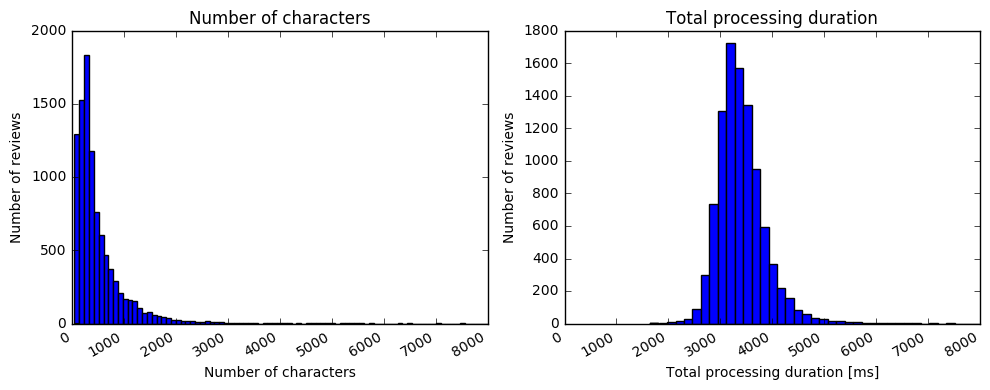

In [19]:
histograms = plt.figure(figsize=(10, 4))
ax1 = histograms.add_subplot(121)
# Aggregate the groupby on mean: all entries for a review should have the same amount of characters
ax1.hist(log_data.groupby('review_id')['character_count'].mean(),bins=100, linewidth=1, edgecolor='black')
ax1.set_ylabel('Number of reviews')
ax1.set_xlabel('Number of characters')
ax1.set_title('Number of characters')
ax1.set_xlim(0,8000)

ax2 = histograms.add_subplot(122)
# Aggregate the groupby on sum: we'll want the total duration reviews spend inside processors
ax2.hist(log_data.groupby('review_id')['duration'].sum(), bins=100, linewidth=1, edgecolor='black')
ax2.set_ylabel('Number of reviews')
ax2.set_xlabel('Total processing duration [ms]')
ax2.set_title('Total processing duration')
ax2.set_xlim(0,8000)

histograms.autofmt_xdate()
plt.tight_layout()
plt.show()

Or, if you prefer density plots:

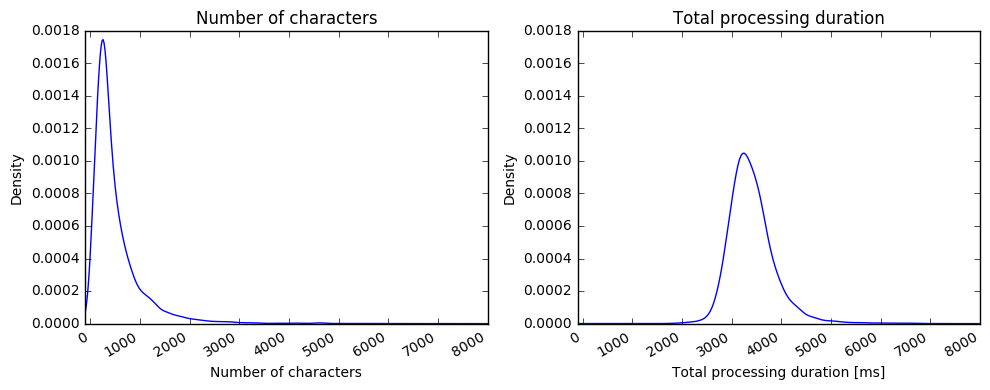

In [20]:
density = plt.figure(figsize=(10, 4))

ax1 = density.add_subplot(121)
log_data.groupby('review_id')['character_count'].mean().plot(kind='density', ax=ax1)
ax1.set_xlim(-100,8000)
ax1.set_xlabel('Number of characters')
ax1.set_title('Number of characters')

ax2 = density.add_subplot(122)
log_data.groupby('review_id')['duration'].sum().plot(kind='density', ax=ax2)
ax2.set_xlim(-100,8000)
ax2.set_xlabel('Total processing duration [ms]')
ax2.set_title('Total processing duration')
ax2.set_ylim(ax1.get_ylim())

density.autofmt_xdate()
plt.tight_layout()
plt.show()

Most reviews are have <2000 characters, and most reviews are processed in under 5 seconds. The shortest reviews consist of 50 characters.

Now, let's see how much time our dataset covers:

In [21]:
log_data['started_at'].max() - log_data['started_at'].min()

Timedelta('0 days 00:21:58.071549')

So, our log data was collected over ~22 minutes.

I'd like to see a correlation matrix of the features. Because built-in correlation computers cannot handle datetime objects, two of our data features need to be converted to integers:

In [22]:
# Use pd.to_numeric to convert values to a numeric type, if they aren't already
tmp = log_data.copy().apply(pd.to_numeric, errors='ignore')

Like before, we'll need to group the entries based on their review_id, and aggregate them: 

In [23]:
tmp.groupby('review_id').agg({'started_at':'min', 'finished_at':'max', 'character_count':'mean',
                               'duration':'sum'}).corr()
# Using Pearson standard correlation coefficient

,character_count,finished_at,duration,started_at
character_count,1.000000,0.125260,0.343354,0.122595
finished_at,0.125260,1.000000,0.073184,0.947541
duration,0.343354,0.073184,1.000000,0.068838
started_at,0.122595,0.947541,0.068838,1.000000


The started_at and finished_at features are heavily correlated, which is to be expected. Longer reviews (higher character_count) take longer to process, and perhaps the longer reviews have been processed later rather than earlier in our 21-minute window. We'll assist these numbers with some plots, starting with the relation between character count and processing time:

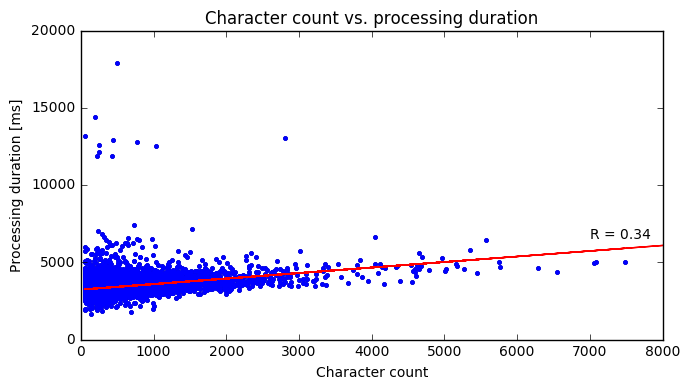

In [24]:
# Aggregate the groupby on mean: all entries for a review should have the same amount of characters
x = log_data.groupby(log_data['review_id'])['character_count'].mean()
# Aggregate the groupby on sum: we'll want the total duration reviews spend inside processors
y = log_data.groupby(log_data['review_id'])['duration'].sum()

fig = plt.figure(figsize=(7,4))
ax = plt.scatter(x, y, marker='.')
plt.xlabel('Character count')
plt.ylabel('Processing duration [ms]')
plt.title('Character count vs. processing duration')
plt.xlim(0,8000)

# Add a fitted 1-d line
m, b = np.polyfit(x, y, 1)
plt.plot(x, y, '.')
plt.plot(x, m*x + b, '-', color='red')
# Calculate Pearson correlation coefficient
plt.text(7000, 6500, 'R = {0:.2}'.format(np.corrcoef(x,y)[0,1]))

plt.tight_layout()
plt.show()

There seems to be some statistical basis for the thought that longer reviews take longer to process, but the relation is not fully linear and not clearly visible from the data. Let's take a look at that other relevant correlation from our correlation matrix, 'started at' vs. 'character count':

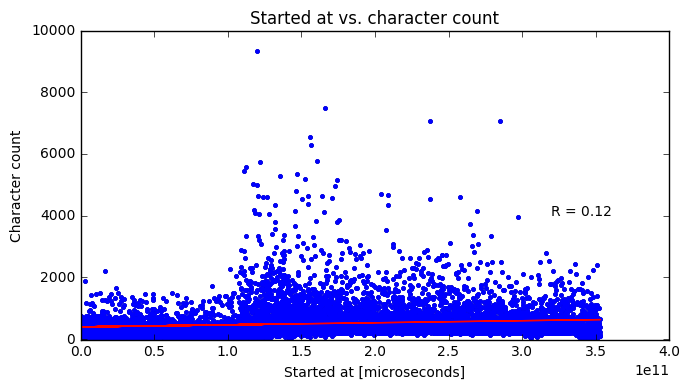

In [25]:
# The plotter won't handle the large integers that result from a conversion of our datetime objects to integers, 
# so we subtract the earliest datetime that exists in our dataset, thereby shifting all datetimes
tmin = log_data['started_at'].min()
# Aggregate the groupby on mean: all entries for a review should have the same amount of characters
x = pd.to_numeric(log_data.groupby(log_data['review_id'])['started_at'].min() - tmin)
# Aggregate the groupby on sum: we'll want the total duration reviews spend inside processors
y = log_data.groupby(log_data['review_id'])['character_count'].mean()

fig = plt.figure(figsize=(7,4))
ax = plt.scatter(x, y, marker='.')
plt.xlabel('Started at [microseconds]')
plt.ylabel('Character count')
plt.title('Started at vs. character count')
plt.xlim(-10,)
plt.ylim(-10,)

# Add a fitted 1-d line
m, b = np.polyfit(x, y, 1)
plt.plot(x, y, '.')
plt.plot(x, m*x + b, '-', color='red')
# Calculate Pearson correlation coefficient
plt.text(320000000000, 4000, 'R = {0:.2}'.format(np.corrcoef(x,y)[0,1]))

plt.tight_layout()
plt.show()

Once again, not a very clear relation. Let's move on to some more advanced and hopefully more insightful plots. 

### More advanced plotting + feature construction

Let's take a look at the duration lengths of the various processor steps. We'll collect all the durations for the various processing steps using a pivot table:

In [26]:
pivot = log_data[['processor','duration']].pivot(columns='processor')
pivot.columns

MultiIndex(levels=[['duration'], ['dependency-parser', 'language-identifier', 'opinion-detector', 'polarity-tagger', 'pos-tagger', 'property-tagger', 'router', 'segmenter', 'semantics-post-processor', 'tokenizer']],
           labels=[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]],
           names=[None, 'processor'])

The columns of this pivot table have been sorted alphabetically from a>z. We already had defined a variable processor_order which contained the true processor order. We will store this alphabetically sorted column order in a separate variable for subsequent usage:

In [27]:
pivot_processor_order = pivot.columns.levels[1].values

We want to collect durations of all processor steps. For the boxplots we're going to make, the durations do not have to be linked to review_id's.

In [28]:
# Initiate empty DF with 1 row for every review, and 10 columns for every processor step
# Make sure the columns are set to be the same as the columns of the pivot table
durations = pd.DataFrame(np.empty([int(pivot.shape[0]/10), 10]), columns=pivot_processor_order)
for idx, processor in enumerate(pivot_processor_order):
    # Select only non-nan values (the pivot contains a lot of nans)
    durations.iloc[:,idx] = pivot.values[:,idx][~np.isnan(pivot.values[:,idx])]
# Put the columns in the desired order (the actual step order, not the pivot table order)
durations = durations[processor_order]

Let's visualize the collected data:

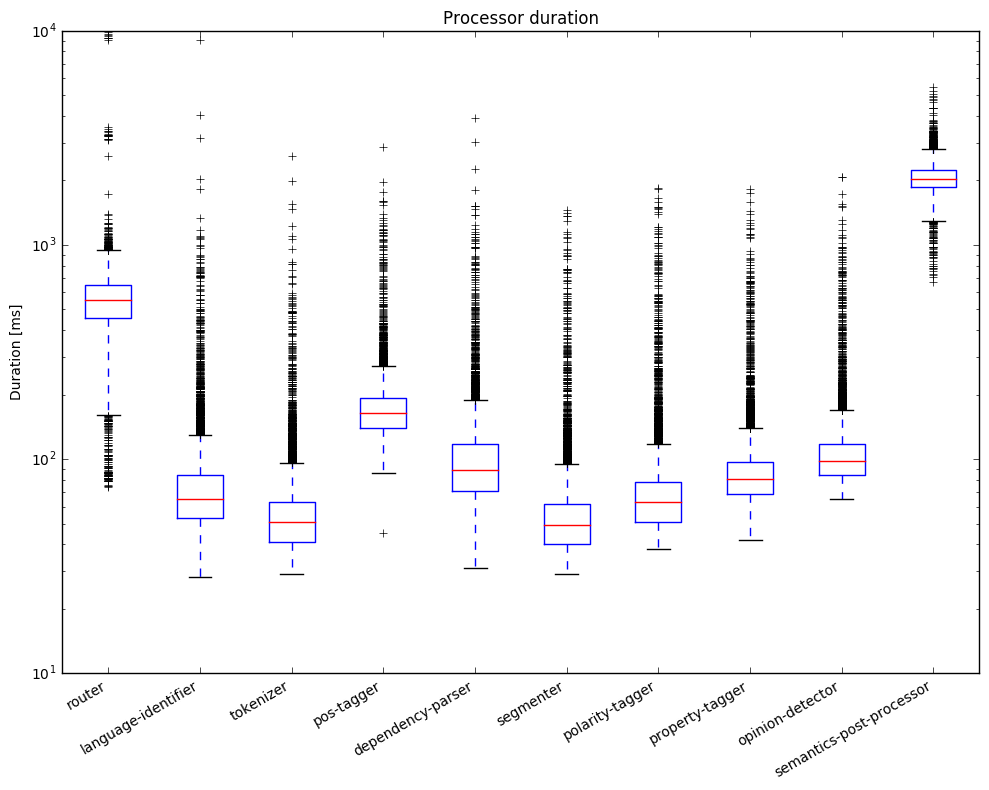

In [29]:
fig, ax = plt.subplots(figsize=(10,8))
ax.boxplot(durations.values)
ax.set_yscale('log')
ax.set_ylabel('Duration [ms]')
ax.set_title('Processor duration')
ax.set_xticklabels(processor_order)
ax.set_ylim(10, 10000)
fig.autofmt_xdate()

plt.tight_layout()
plt.show()

The above steps (collecting + plotting) could have been done more quickly using panda's 
df.boxplot() (code below), but the the various processors are not ordered correctly in that case, which can be confusing: 
```python
fig = plt.figure()
ax = log_data.boxplot('duration', by='processor', rot=90, figsize=(10,8))
fig = ax.get_figure()
fig.suptitle('')
ax.set_yscale('log')
ax.set_ylabel('Duration [ms]')
ax.set_title('Processor duration')
ax.set_xlabel('')
plt.tight_layout()
plt.show()
```

It is clear that the 'router' and the 'semantics-post-processor' steps take much more time than the other processor steps (mind the logarithmic vertical scale!). All processors have outliers that take relatively long to complete though.

Besides being processed, reviews also spend time inbetween processors, when they are being transfered from processor to processor and possibly wait to be processed. We'll calculate these durations, which we can consider to be a new feature of the reviews.

In [30]:
# The code in the cell below takes a few minutes to run. Alternatively you could uncomment the import and pickle load lines 
# below, bypassing the calculations

#import pickle
#wait_feature = pickle.load(open('wait_feature.p','rb'))
##pickle.dump(wait_feature, open('wait_feature.p','wb'))

In [ ]:
# Collect the data for all reviews in a DF
wait_feature = pd.DataFrame(np.empty([0, 3]))

for review_id in log_data['review_id'].unique():
    # Collect the data for 1 review in a small DF
    wait_time = pd.DataFrame(np.empty([10, 3]))
    # Create boolean mask to select all entries that belong to the same review
    review_mask = log_data['review_id']==review_id
    # Collect the processor steps of a review, sorted by their start time
    sorted_steps = log_data.loc[review_mask].sort_values(by='started_at')
    # Assign the review_id and processor steps to the small DF
    wait_time.iloc[:,0] = review_id
    wait_time.iloc[:,1] = sorted_steps['processor'].values
    # There are 10 processor steps, so 9 'in-between processor' phases
    # In every small DF, the first entry will therefore be assigned a 0
    for i in range(sorted_steps.shape[0]):
        if i == 0:
            wait_time.iloc[i, 2] = 0
        else: 
            # The wait/transfer time inbetween step i and the step before i is calculated
            # as the 'started_at' timestamp of step i minus the 'finished_at' timestamp of the
            # step before, step i-1
            wait_time.iloc[i, 2] = (sorted_steps['started_at'].iloc[i]-
                                    sorted_steps['finished_at'].iloc[i-1]).total_seconds()*1000
    
    # Append the smaller DF to the overall DF
    wait_feature = wait_feature.append(wait_time, ignore_index=True)
    
wait_feature.columns = ['review_id', 'processor', 'wait time']

We'll merge this new feature with the existing log_data DF:

In [31]:
log_data = pd.merge(log_data, wait_feature, left_on=['review_id','processor'], right_on=['review_id','processor'])

We will collect all the wait durations for the various inter-processor steps using a pivot table, like before:

In [32]:
pivot = log_data[['processor','wait time']].pivot(columns='processor')
pivot.columns

MultiIndex(levels=[['wait time'], ['dependency-parser', 'language-identifier', 'opinion-detector', 'polarity-tagger', 'pos-tagger', 'property-tagger', 'router', 'segmenter', 'semantics-post-processor', 'tokenizer']],
           labels=[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]],
           names=[None, 'processor'])

In [33]:
# Store pivot table processor order in a variable
pivot_processor_order = pivot.columns.levels[1].values

In [34]:
# Initiate empty DF with 1 row for every review, and 10 columns for every processor step
# Make sure the columns are set to be the same as the columns of the pivot table
wait_durations = pd.DataFrame(np.empty([int(pivot.shape[0]/10), 10]), columns=pivot_processor_order)
for idx, processor in enumerate(pivot_processor_order):
    # Select only non-nan values (the pivot contains a lot of nans)
    wait_durations.iloc[:,idx] = pivot.values[:,idx][~np.isnan(pivot.values[:,idx])]

# Put the columns in the desired order (the actual step order, not the alphabetical one)
wait_durations = wait_durations[processor_order]
# Drop the 'router' column which only contains values of 0
wait_durations.drop('router', axis=1, inplace=True)
# Attach more descriptive labels to the columns
wait_durations.columns = ['router > language-identifier',
'language-identifier > tokenizer',
'tokenizer > pos-tagger',
'pos-tagger > dependency-parser',
'dependency-parser > segmenter',
'segmenter > polarity-tagger',
'polarity-tagger > property-tagger',
'property-tagger > opinion-detector',
'opinion-detector > semantics-post-processor']

What we'd like to see is of course an overall plot including both the processor and the wait phases:

In [35]:
# Concatenate the durations and the wait_durations DFs
total_times = pd.concat([durations, wait_durations], axis=1)

# Put the DF in the desired order
total_times = total_times[['router',
'router > language-identifier',
'language-identifier',
'language-identifier > tokenizer',
'tokenizer',
'tokenizer > pos-tagger',
'pos-tagger',
'pos-tagger > dependency-parser',
'dependency-parser',
'dependency-parser > segmenter',
'segmenter',
'segmenter > polarity-tagger',
'polarity-tagger',
'polarity-tagger > property-tagger',
'property-tagger',
'property-tagger > opinion-detector',
'opinion-detector',
'opinion-detector > semantics-post-processor',
'semantics-post-processor']]

Let's visualize the data:

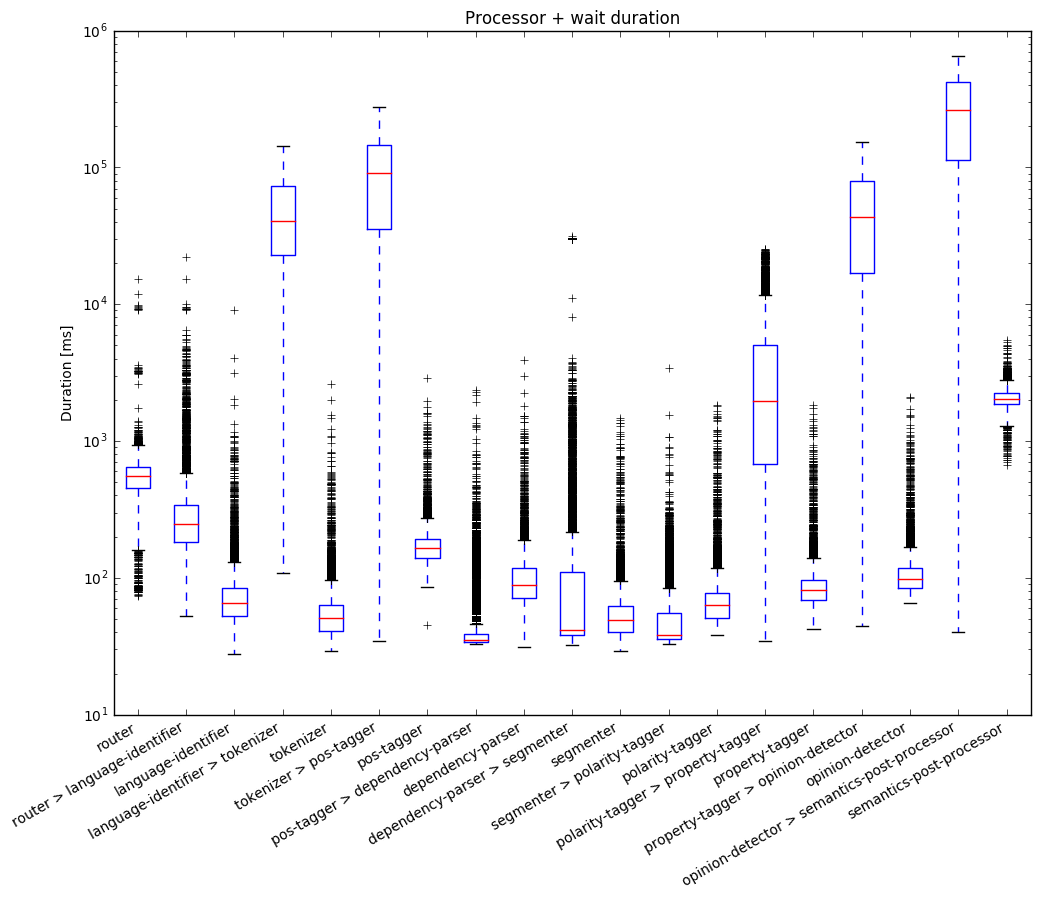

In [36]:
fig, ax = plt.subplots(figsize=(10,9))
ax.boxplot(total_times.values)
ax.set_yscale('log')
ax.set_ylabel('Duration [ms]')
ax.set_title('Processor + wait duration')
ax.set_xlabel('')
ax.set_xticklabels(total_times.columns, rotation=90)
plt.tight_layout()
fig.autofmt_xdate()

plt.show()

In [37]:
print('Mean time spent being processed: {} ms'.format(int(durations.mean().sum())))
print('Mean time spent inbetween processors: {} ms'.format(int(wait_durations.mean().sum())))

Mean time spent being processed: 3415 ms
Mean time spent inbetween processors: 477034 ms


The reviews seem to spend much more time inbetween processors than being processed. These time-consuming phases are not necessarily bottlenecks in the overall processing of course, if the computing resources are allocated accordingly. 

We observed from the correlation matrix that there is barely a correlation between the 'started_at' and the 'duration' features. Let's create a scatter plot of these features:

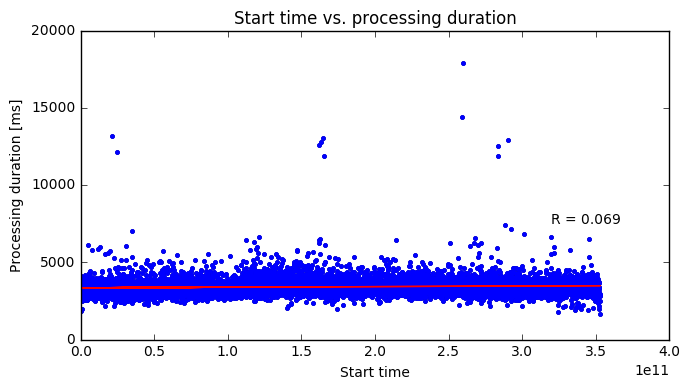

In [38]:
# The plotter won't handle the large integers that result from a conversion of our datetime objects to integers, 
# so we subtract the earliest datetime that exists in our dataset, thereby shifting all datetimes
tmin = log_data['started_at'].min()
# Aggregate the groupby on min: take the start time of the first processor of the review
x = pd.to_numeric(log_data.groupby(log_data['review_id'])['started_at'].min() - tmin)
# Aggregate the groupby on sum: we'll want the total duration reviews spend inside processors
y = pd.to_numeric(log_data.groupby('review_id')['duration'].sum())

fig = plt.figure(figsize=(7,4))
ax = plt.scatter(x, y, marker='.')
plt.xlabel('Start time')
plt.ylabel('Processing duration [ms]')
plt.title('Start time vs. processing duration')
plt.xlim(0,)

# Add a fitted 1-d line
m, b = np.polyfit(x, y, 1)
plt.plot(x, y, '.')
plt.plot(x, m*x + b, '-', color='red')
# Calculate Pearson correlation coefficient
plt.text(320000000000, 7500, 'R = {0:.2}'.format(np.corrcoef(x,y)[0,1]))

plt.tight_layout()
plt.show()

Indeed, the data doesn't seem to show a trend. We have also observed before that the reviews spend (on average) much more time inbetween processor stages than they do being processed. So what happens when we plot the start time vs. the total duration that a review spends from the start in the first processor to the finish in the last processor, i.e. the total time a review spends in the NLP processing pipeline? 

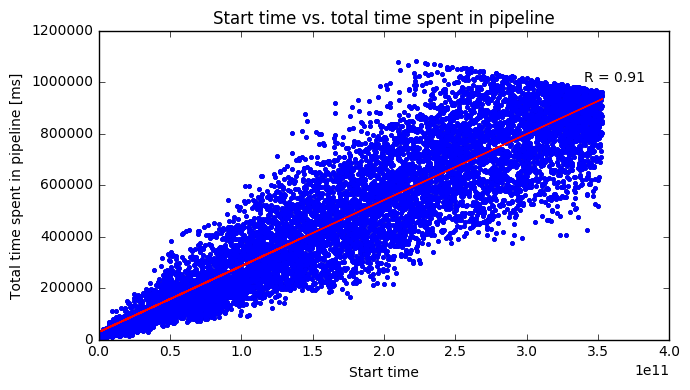

In [39]:
# The plotter won't handle the large integers that result from a conversion of our datetime objects to integers, 
# so we subtract the earliest datetime that exists in our dataset, thereby shifting all datetimes
tmin = log_data['started_at'].min()
# Aggregate the groupby on min: take the start time of the first processor of the review
x = pd.to_numeric(log_data.groupby(log_data['review_id'])['started_at'].min() - tmin)
# Aggregate the groupby on sum: we'll want the total duration reviews spend inside processors and inbetween processors
# Sum the results again to sum the processor and wait/transfer times
y = log_data.groupby('review_id')[['duration', 'wait time']].sum().sum(axis=1)

fig = plt.figure(figsize=(7,4))
ax = plt.scatter(x, y, marker='.')
plt.xlabel('Start time')
plt.ylabel('Total time spent in pipeline [ms]')
plt.title('Start time vs. total time spent in pipeline')
plt.xlim(0,)
plt.ylim(0,)

# Add a fitted 1-d line
m, b = np.polyfit(x, y, 1)
plt.plot(x, y, '.')
plt.plot(x, m*x + b, '-', color='red')
# Calculate Pearson correlation coefficient
plt.text(340000000000, 1000000, 'R = {0:.2}'.format(np.corrcoef(x,y)[0,1]))

plt.tight_layout()
plt.show()

Here we observe something strange: the start time is heavily correlated with the total time a review spends in the pipeline. The later a review was processed, the longer it took for it to finish. One explanation could be that there is a bottleneck in the pipeline; reviews keep piling up in front of this bottleneck, waiting to pass through. As their number increases, they have to wait longer on average to indeed pass through. Let's see if we can visualize any such bottlenecks:

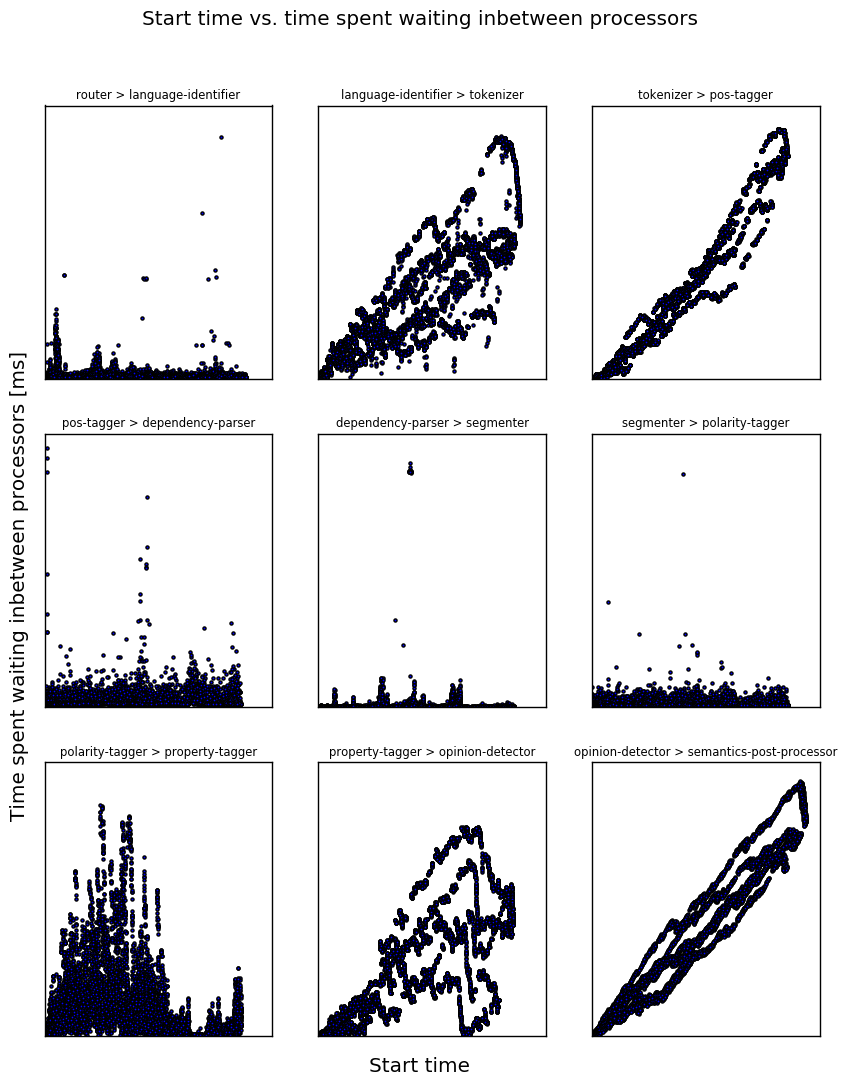

In [40]:
fig = plt.figure(figsize=(10,12))

for idx, processor in enumerate(processor_order[1:]):
    processor_mask = log_data['processor']==processor
    x = pd.to_numeric(log_data[processor_mask]['started_at'] - tmin)
    y = log_data[processor_mask]['wait time']

    ax = fig.add_subplot(3,3,idx+1)
    ax = plt.scatter(x, y, marker='.')
    plt.xticks([])
    plt.yticks([])
    #plt.xlabel('Start time')
    #plt.ylabel('Time spent waiting for next processor [ms]')
    #plt.title('{}: start time vs. time spent waiting for next processor'.format(processor))
    plt.title('{}'.format(wait_durations.columns[idx]), size='small')    
    plt.xlim(0,)
    plt.ylim(0,)
    
# Set common labels
fig.suptitle('Start time vs. time spent waiting inbetween processors', size='x-large')
fig.text(0.5, 0.1, 'Start time', size='x-large', ha='center', va='center')
fig.text(0.1, 0.5, 'Time spent waiting inbetween processors [ms]', size='x-large', ha='center', va='center', rotation='vertical')

#plt.tight_layout()
plt.show()

It seems that there are multiple bottlenecks. The phases:
- language-identifier > tokenizer 
- tokenizer > pos-tagger
- property-tagger > opinion-detector
- opinion-detector > semantics-post-processor

seem to take longer as the start time is increasing. 

This could mean that the 
- tokenizer
- pos-tagger
- opiniion-detector
- semantics-post-processor 

processors are bottlenecks in the pipeline, which should be checked by the engineering team. I would advise to eliminate such bottlenecks, e.g. by allocating more processing resources to them, before basing any NLP pipeline runtime estimations on a set of test data. It would be possible to train a regression model on the dataset as it is, in order to predict pipeline runtimes, but 'start time' / 'elapsed time since pipeline was activated' would be an important feature in that and that is probably not desirable.